In [1]:
import warnings
warnings.filterwarnings('ignore',category=RuntimeWarning)
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import glob,os,sys
from tqdm.auto import tqdm
import proplot as plot
import json,pickle
import dask.array as da
import gc
from sklearn.decomposition import PCA
sys.path.insert(1, '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/')
from tools import derive_var,read_and_proc,preproc_noensemble
from tools.mlr import mlr,proc_mlrfcst,maria_IO
from tools.preprocess import do_eof,preproc_maria,preproc_haiyan
sys.path.insert(2, '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/testML/')
import feature_select
from dask.distributed import Client
client = Client(processes=True, threads_per_worker=1,n_workers=2)
%matplotlib inline
plot.rc.update({'figure.facecolor':'w','axes.labelweight':'ultralight',
                'tick.labelweight':'ultralight','gridminor.linestyle':'--','title.weight':'normal','linewidth':0.5})

/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/miniconda3/envs/fred_workenv/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46357 instead
  warnings.warn(
/tmp/ipykernel_1531491/2472673958.py:24: ProplotWarning: rc setting 'linewidth' was renamed to 'meta.width' in version 0.8.
  plot.rc.update({'figure.facecolor':'w','axes.labelweight':'ultralight',


In [2]:
def forward_diff(arrayin=None,delta=None,axis=None,LT=1):
    result = []
    if axis==0:
        for i in range(0,arrayin.shape[axis]-LT):
            temp = (arrayin[i+LT,:]-arrayin[i,:])/(LT*delta)
            result.append(temp)
        return np.asarray(result)
    
class retrieve_cartesian:
    def __init__(self,PCA_dict=None,Af_dict=None,numcomp=[11,11,15],LT=None,forecastPC=None,target='all',suffix=None):
        self.PCA_dict=PCA_dict
        self.numcomp=numcomp
        self.forecastPC = forecastPC
        self.LT = LT
        self.target=target
        self.suffix=suffix
        
    def get_time_diff_terms(self,inputvar=None,LT=None,wantvar=None):
        def _get_time_diff(array=None,timedelta=60*60,LT=None):
            store = []
            for exp in array:
                a = forward_diff(exp,timedelta,0,LT)
                if a.shape[0]>0:
                    azero = np.zeros((LT,exp.shape[-1]))
                    store.append(np.asarray(a))
                    #store.append(np.concatenate((a,azero),axis=0))
                else:
                    continue
                    #store.append(np.zeros((exp.shape[0],exp.shape[-1])))
            return store
        
        storedict = {}
        for wantvarZ,wantvarN in enumerate(wantvar):
            storedict[wantvarN] = _get_time_diff(array=inputvar[wantvarZ],LT=LT)
        return storedict
    
    def _pop_valid_test(self,examplist=None,validindex=None,testindex=None):
        popindex = validindex+testindex
        return [examplist[i] for i in range(len(examplist)) if i not in popindex]
        #[examplist.pop(i) for i in validindex]
        #[examplist.pop(i) for i in testindex]
        #return None
        
    def windrates_real(self,uvwheatpath=None,LT=None,category='train',validindex=[1,6],testindex=[2,12]):
        u = [read_and_proc.depickle(path+uvwheatpath+'mem'+str(lime)+self.suffix)['u'] for lime in tqdm(range(1,21))].copy()
        v = [read_and_proc.depickle(path+uvwheatpath+'mem'+str(lime)+self.suffix)['v'] for lime in tqdm(range(1,21))].copy()
        w = [read_and_proc.depickle(path+uvwheatpath+'mem'+str(lime)+self.suffix)['w'] for lime in tqdm(range(1,21))].copy()
        theta = [read_and_proc.depickle(path+uvwheatpath+'mem'+str(lime)+self.suffix)['theta'] for lime in tqdm(range(1,21))].copy()
        
        if category=='train':
            self._pop_valid_test(u,validindex,testindex)
            self._pop_valid_test(v,validindex,testindex)
            self._pop_valid_test(w,validindex,testindex)
            self._pop_valid_test(theta,validindex,testindex)
            assert len(u)==16, 'wrong train-valid-test separation!'
            dtermsT = self.get_time_diff_terms(inputvar=[u,v,w,theta],LT=LT,wantvar=['u','v','w','theta'])
        elif category=='valid':
            uv = [u[index] for index in validindex]
            vv = [v[index] for index in validindex]
            wv = [w[index] for index in validindex]
            thetav = [theta[index] for index in validindex]
            del u,v,w,theta
            gc.collect()
            dtermsT = self.get_time_diff_terms(inputvar=[uv,vv,wv,thetav],LT=LT,wantvar=['u','v','w','theta'])
        elif category=='test':
            ut = [u[index] for index in testindex]
            vt = [v[index] for index in testindex]
            wt = [w[index] for index in testindex]
            thetat = [theta[index] for index in testindex]            
            del u,v,w,theta
            gc.collect()
            dtermsT = self.get_time_diff_terms(inputvar=[ut,vt,wt,thetat],LT=LT,wantvar=['u','v','w','theta'])            
        
        dudt = np.concatenate([testx for testx in dtermsT['u']],axis=0)
        dvdt = np.concatenate([testx for testx in dtermsT['v']],axis=0)
        dwdt = np.concatenate([testx for testx in dtermsT['w']],axis=0)
        dthdt = np.concatenate([testx for testx in dtermsT['theta']],axis=0)
        del dtermsT
        gc.collect()
        return dudt,dvdt,dwdt,dthdt
    
    def output_reshapeRECON(self,forecast_eig=None):
        if (self.target=='surface') or (self.target=='alluv'):
            testrec_dudt = np.dot(forecast_eig[:,0:self.numcomp[0]],(self.PCA_dict['u'].components_[0:self.numcomp[0]]))#.reshape((91,39,360,167))
            testrec_dvdt = np.dot(forecast_eig[:,self.numcomp[0]:self.numcomp[0]+self.numcomp[1]],(self.PCA_dict['v'].components_[0:self.numcomp[1]]))#.reshape((91,39,360,167))
            return testrec_dudt,testrec_dvdt
        else:
            testrec_dudt = np.dot(forecast_eig[:,0:self.numcomp[0]],(self.PCA_dict['u'].components_[0:self.numcomp[0]]))#.reshape((91,39,360,167))
            testrec_dvdt = np.dot(forecast_eig[:,self.numcomp[0]:self.numcomp[0]+self.numcomp[1]],(self.PCA_dict['v'].components_[0:self.numcomp[1]]))#.reshape((91,39,360,167))
            testrec_dwdt = np.dot(forecast_eig[:,self.numcomp[0]+self.numcomp[1]:self.numcomp[0]+self.numcomp[1]+self.numcomp[2]],(self.PCA_dict['w'].components_[0:self.numcomp[2]]))#.reshape((39,360,167))
            testrec_dthdt = np.dot(forecast_eig[:,self.numcomp[0]+self.numcomp[1]+self.numcomp[2]:],(self.PCA_dict['theta'].components_[0:self.numcomp[3]]))#.reshape((39,360,167))
            return testrec_dudt,testrec_dvdt,testrec_dwdt,testrec_dthdt
        
    def conversion_predictPC(self,yforecast=None,mshpe=[39,360,167]):
        if self.target=='surface':
            t1,t2 = self.output_reshapeRECON(forecast_eig=yforecast)
            return (t1.reshape(t1.shape[0],mshpe[0],mshpe[1],mshpe[2])[:,0,:,:]).reshape(t1.shape[0],mshpe[1]*mshpe[2]),(t2.reshape(t2.shape[0],mshpe[0],mshpe[1],mshpe[2])[:,0,:,:]).reshape(t2.shape[0],mshpe[1]*mshpe[2])
        elif self.target=='alluv':
            t1,t2 = self.output_reshapeRECON(forecast_eig=yforecast)
            return t1,t2
        elif self.target=='all': 
            t1,t2,t3,t4 = self.output_reshapeRECON(forecast_eig=yforecast)
            return t1,t2,t3,t4
        
    def output_r2(self,FFWmodels=None,reducedX=None,realU=None,realV=None,realW=None,realTH=None,case='Haiyan'):
        yf = [models.predict(Xns) for (models,Xns) in zip(FFWmodels[:],reducedX[:])]
        mlr_r2 = []
        for i in (range(45)):#len(yf))):
            if case=='Maria':
                temp1,temp2 = self.conversion_predictPC(yforecast=yf[i],mshpe=[39,360,167])
                mlr_r2.append(r2_score(np.concatenate((realU,realV),axis=0),np.concatenate((temp1,temp2),axis=0)))
            elif case=='Haiyan':
                try:
                    temp1,temp2 = self.conversion_predictPC(yforecast=yf[i],mshpe=[10,360,208])
                    a = r2_score(np.concatenate((realU,realV),axis=0),np.concatenate((temp1,temp2),axis=0))
                    print(a)
                    mlr_r2.append(a)
                except:
                    temp1,temp2,temp3,temp4 = self.conversion_predictPC(yforecast=yf[i],mshpe=[10,360,208])
                    a = r2_score(np.concatenate((realU,realV,realW,realTH),axis=0),np.concatenate((temp1,temp2,temp3,temp4),axis=0))
                    print(a)
                    mlr_r2.append(a)
            del temp1,temp2
            gc.collect()
        return mlr_r2
    
def output_realdterms(haiyan_data=None,category='train',varnum=2,LT=24):
    if varnum==2:
        a,b,_,_ = retrieve_cartesian(PCA_dict=None,Af_dict=haiyan_data,numcomp=None,LT=24,forecastPC=None,\
                                  target='all',suffix=suffix).windrates_real(uvwheatpath='TCGphy/testML/output/haiyan/processed/uvwheat/',\
                                                                             LT=LT,category=category,validindex=[1,6],testindex=[2,12])
        return a,b
    elif varnum==4:
        a,b,c,d = retrieve_cartesian(PCA_dict=None,Af_dict=haiyan_data,numcomp=None,LT=24,forecastPC=None,\
                                  target='all',suffix=suffix).windrates_real(uvwheatpath='TCGphy/testML/output/haiyan/processed/uvwheat/',\
                                                                             LT=LT,category=category,validindex=[1,6],testindex=[2,12])     
        return a,b,c,d

In [ ]:
lti=24
path = '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/'
suffix = '_smooth_preproc_dict1b_g'
realdu,realdv,realdw,realdtheta = output_realdterms(category='train',varnum=4,LT=lti)
realdu_valid,realdv_valid,realdw_valid,realdtheta_valid = output_realdterms(category='valid',varnum=4,LT=lti)
realdu_test,realdv_test,realdw_test,realdtheta_test = output_realdterms(category='test',varnum=4,LT=lti)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

#### Real du/dv

In [31]:
realsurfu,realsurfv = realdu.reshape(realdu.shape[0],10,360,208)[:,0,:,:].reshape(realdu.shape[0],360*208),realdv.reshape(realdv.shape[0],10,360,208)[:,0,:,:].reshape(realdu.shape[0],360*208)
deltawspd = np.sqrt(realsurfu**2+realsurfv**2)
deltawspd_normal = (deltawspd-np.nanmean(deltawspd))/np.nanstd(deltawspd)

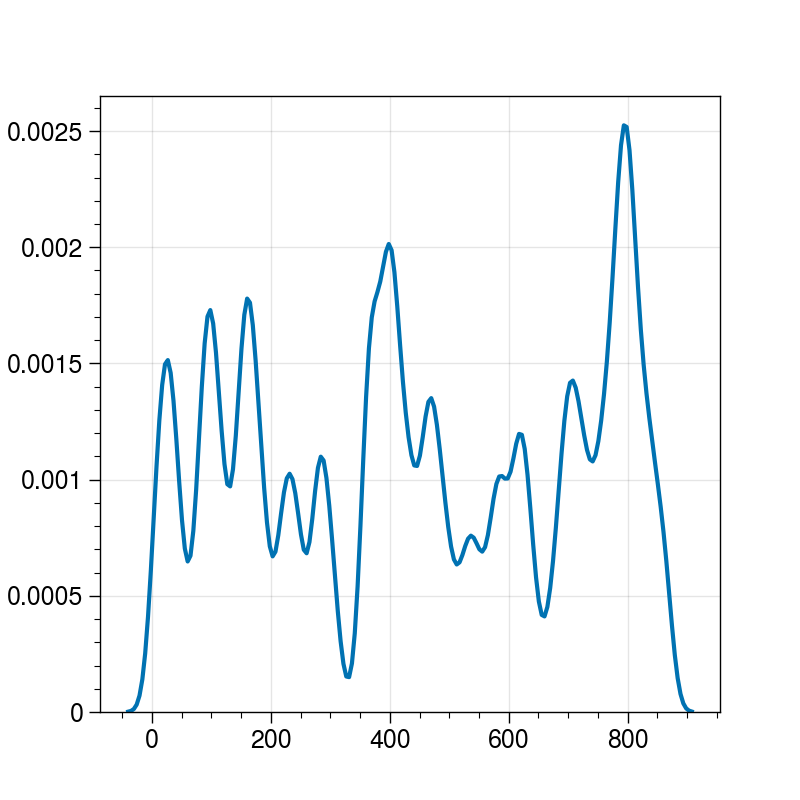

In [200]:
sns.kdeplot(np.argwhere(deltawspd_normal>np.nanpercentile(deltawspd_normal,95))[:,0])
plt.show()
#(deltawspd[deltawspd>np.nanpercentile(deltawspd,95)])

#### Model Ensemble

In [4]:
lti = 24
model = read_and_proc.depickle('../output/haiyan/processed/pca/FFW/'+str(lti)+'/FFWmodels_cross7')
new_feature = read_and_proc.depickle('../output/haiyan/processed/pca/FFW/'+str(lti)+'/newfeature_cross7')
reducedX = read_and_proc.depickle('../output/haiyan/processed/pca/FFW/'+str(lti)+'/reducedX_cross7')

In [5]:
def feature_importance_from_mlr(MODEL=None,smallX=None):
    def _get_feature_importance(WEIGHTx=None,smallXx=None):
        return np.nanmean(np.asarray([temp*smallXx for temp in WEIGHTx]),axis=1)
    weight = MODEL.coef_
    #WEIGHTZ = np.zeros_like(weight)
    return np.asarray([_get_feature_importance(weight[:,weightz],smallX[:,weightz]) for weightz in range(smallX.shape[1])])

In [6]:
def feature_importance_from_mlr(MODEL=None,smallX=None):
    def _get_feature_importance(WEIGHTx=None,smallXx=None):
        return np.nanmean(np.asarray([temp*smallXx for temp in WEIGHTx]),axis=1)
    weight = MODEL.coef_
    #WEIGHTZ = np.zeros_like(weight)
    return np.asarray([_get_feature_importance(weight[:,weightz],smallX[:,weightz]) for weightz in range(smallX.shape[1])])
ensemble_weights = [feature_importance_from_mlr(MODEL=model[i],smallX=reducedX[i]) for i in range(20)]

In [20]:
# 191 (12th LW), 184 (5th LW), 187 (8th LW), 72 (22nd V), 7 (8th U), 26 (27th U), 214 (17th LW)
np.asarray([50,38,91,8]).cumsum()

array([ 50,  88, 179, 187])

In [39]:
sorted([191,184,187,72,7,26])

[7, 26, 72, 184, 187, 191]

/tmp/ipykernel_1402975/3248261403.py:8: ProplotWarning: rc setting 'linewidth' was renamed to 'meta.width' in version 0.8.
  plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'k','title.color':'w','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})


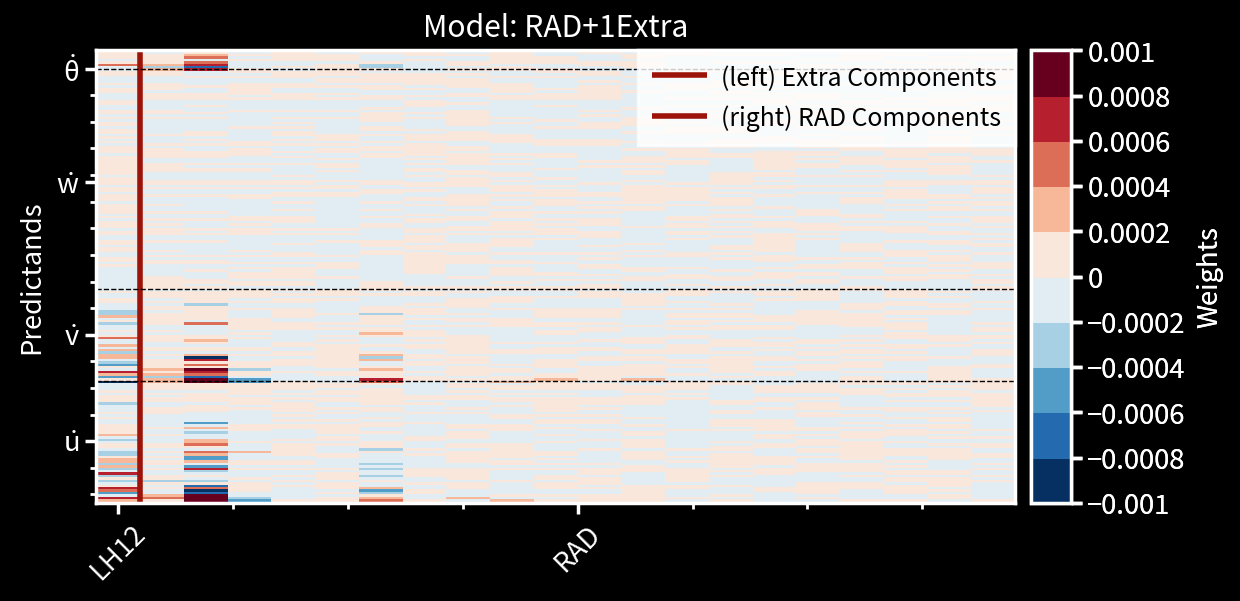

In [8]:
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from matplotlib.lines import Line2D
#for i in range(20):
i=0
plot.rc.metacolor = 'w'
plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'k','title.color':'w','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})
plot.rc.axesfacecolor = 'k'

fig,axs = plot.subplots(ncols=1,nrows=1,axwidth=4.595,refaspect=2.031)
l = axs[0].pcolormesh(np.linspace(0,20+i,21+i)-0.5,np.linspace(0,186,187),ensemble_weights[i].transpose(),cmap='BuRd',vmin=-0.001,vmax=0.001)
#axs.format(ylabel='Predictands',xticks=[-0.5,1-0.5,2-0.5,3-0.5,4-0.5,5-0.5,10+i],yticks=[25,69,132,179],yticklabels=['$\dot{u}$','$\dot{v}$','$\dot{w}$',r'$\dot{\theta}$'],\
#          xticklabels=['U8','U27','V22','LH5','LH8','LH12','RAD'],title=f'Model: RAD+{i+1}Extra')
axs.format(ylabel='Predictands',xticks=[-0.5,10+i],yticks=[25,69,132,179],yticklabels=['$\dot{u}$','$\dot{v}$','$\dot{w}$',r'$\dot{\theta}$'],\
          xticklabels=['LH12','RAD'],title=f'Model: RAD+{i+1}Extra')
l2 = axs[0].axvline(i,lw=2,color='#9c1309')
for ix in [50,88,179]:
    axs[0].axhline(ix,lw=0.5,color='k',ls='--')
custom_lines = [Line2D([0], [0], color='#9c1309', lw=2),Line2D([0], [0], color='#9c1309', lw=2)]
axs[0].legend(custom_lines, ['(left) Extra Components', '(right) RAD Components'],loc='ur',ncols=1,prop={'size':10})
plt.colorbar(l,ax=axs[0],label='Weights')
for tick in axs[0].get_xticklabels():
    tick.set_rotation(45)
plt.savefig('../figures/0430/weights_'+str(i)+'.png',dpi=300,facecolor=fig.get_facecolor())
plt.show()

In [62]:
def flatten(t):
    return [item for sublist in t for item in sublist]

In [63]:
tocount_2,tocount_6 = flatten([np.argsort(np.abs(ensemble_weights[i][i+2,:]))[-3:] for i in range(20)]),flatten([np.argsort(np.abs(ensemble_weights[i][i+6,:]))[-3:] for i in range(20)])
tocount_2_pos,tocount_6_pos = flatten([np.argsort((ensemble_weights[i][i+2,:]))[-3:] for i in range(20)]),flatten([np.argsort((ensemble_weights[i][i+6,:]))[-3:] for i in range(20)])
print(f"Results for 2nd RAD PC: {dict([(str(ele),tocount_2.count(ele)) for ele in set(tocount_2)])}")
print(f"Results for 6th RAD PC: {dict([(str(ele),tocount_6.count(ele)) for ele in set(tocount_6)])}")

Results for 2nd RAD PC: {'64': 6, '1': 7, '2': 2, '66': 3, '7': 10, '12': 1, '50': 10, '51': 10, '180': 9, '55': 2}
Results for 6th RAD PC: {'0': 6, '1': 10, '2': 4, '66': 3, '7': 7, '12': 10, '55': 10, '59': 10}


In [66]:
dict2,dict6 = dict([(str(ele),tocount_2_pos.count(ele)) for ele in set(tocount_2_pos)]),dict([(str(ele),tocount_6_pos.count(ele)) for ele in set(tocount_6_pos)])
dict2k,dict2v,dict6k,dict6v = list(dict2.keys()),list(dict2.values()),list(dict6.keys()),list(dict6.values())

/tmp/ipykernel_3218691/2950504816.py:2: ProplotWarning: rc setting 'linewidth' was renamed to 'meta.width' in version 0.8.
  plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'k','title.color':'w','fontname': 'Source Sans Pro', 'fontsize': 13,'linewidth':1.25})
/tmp/ipykernel_3218691/2950504816.py:14: ProplotWarning: Calling arbitrary axes methods from SubplotGrid was deprecated in v0.8 and will be removed in a future release. Please index the grid or loop over the grid instead.
  axs.grid(color='lightgray',lw=0.5,alpha=0.6,ls='--',zorder=0)


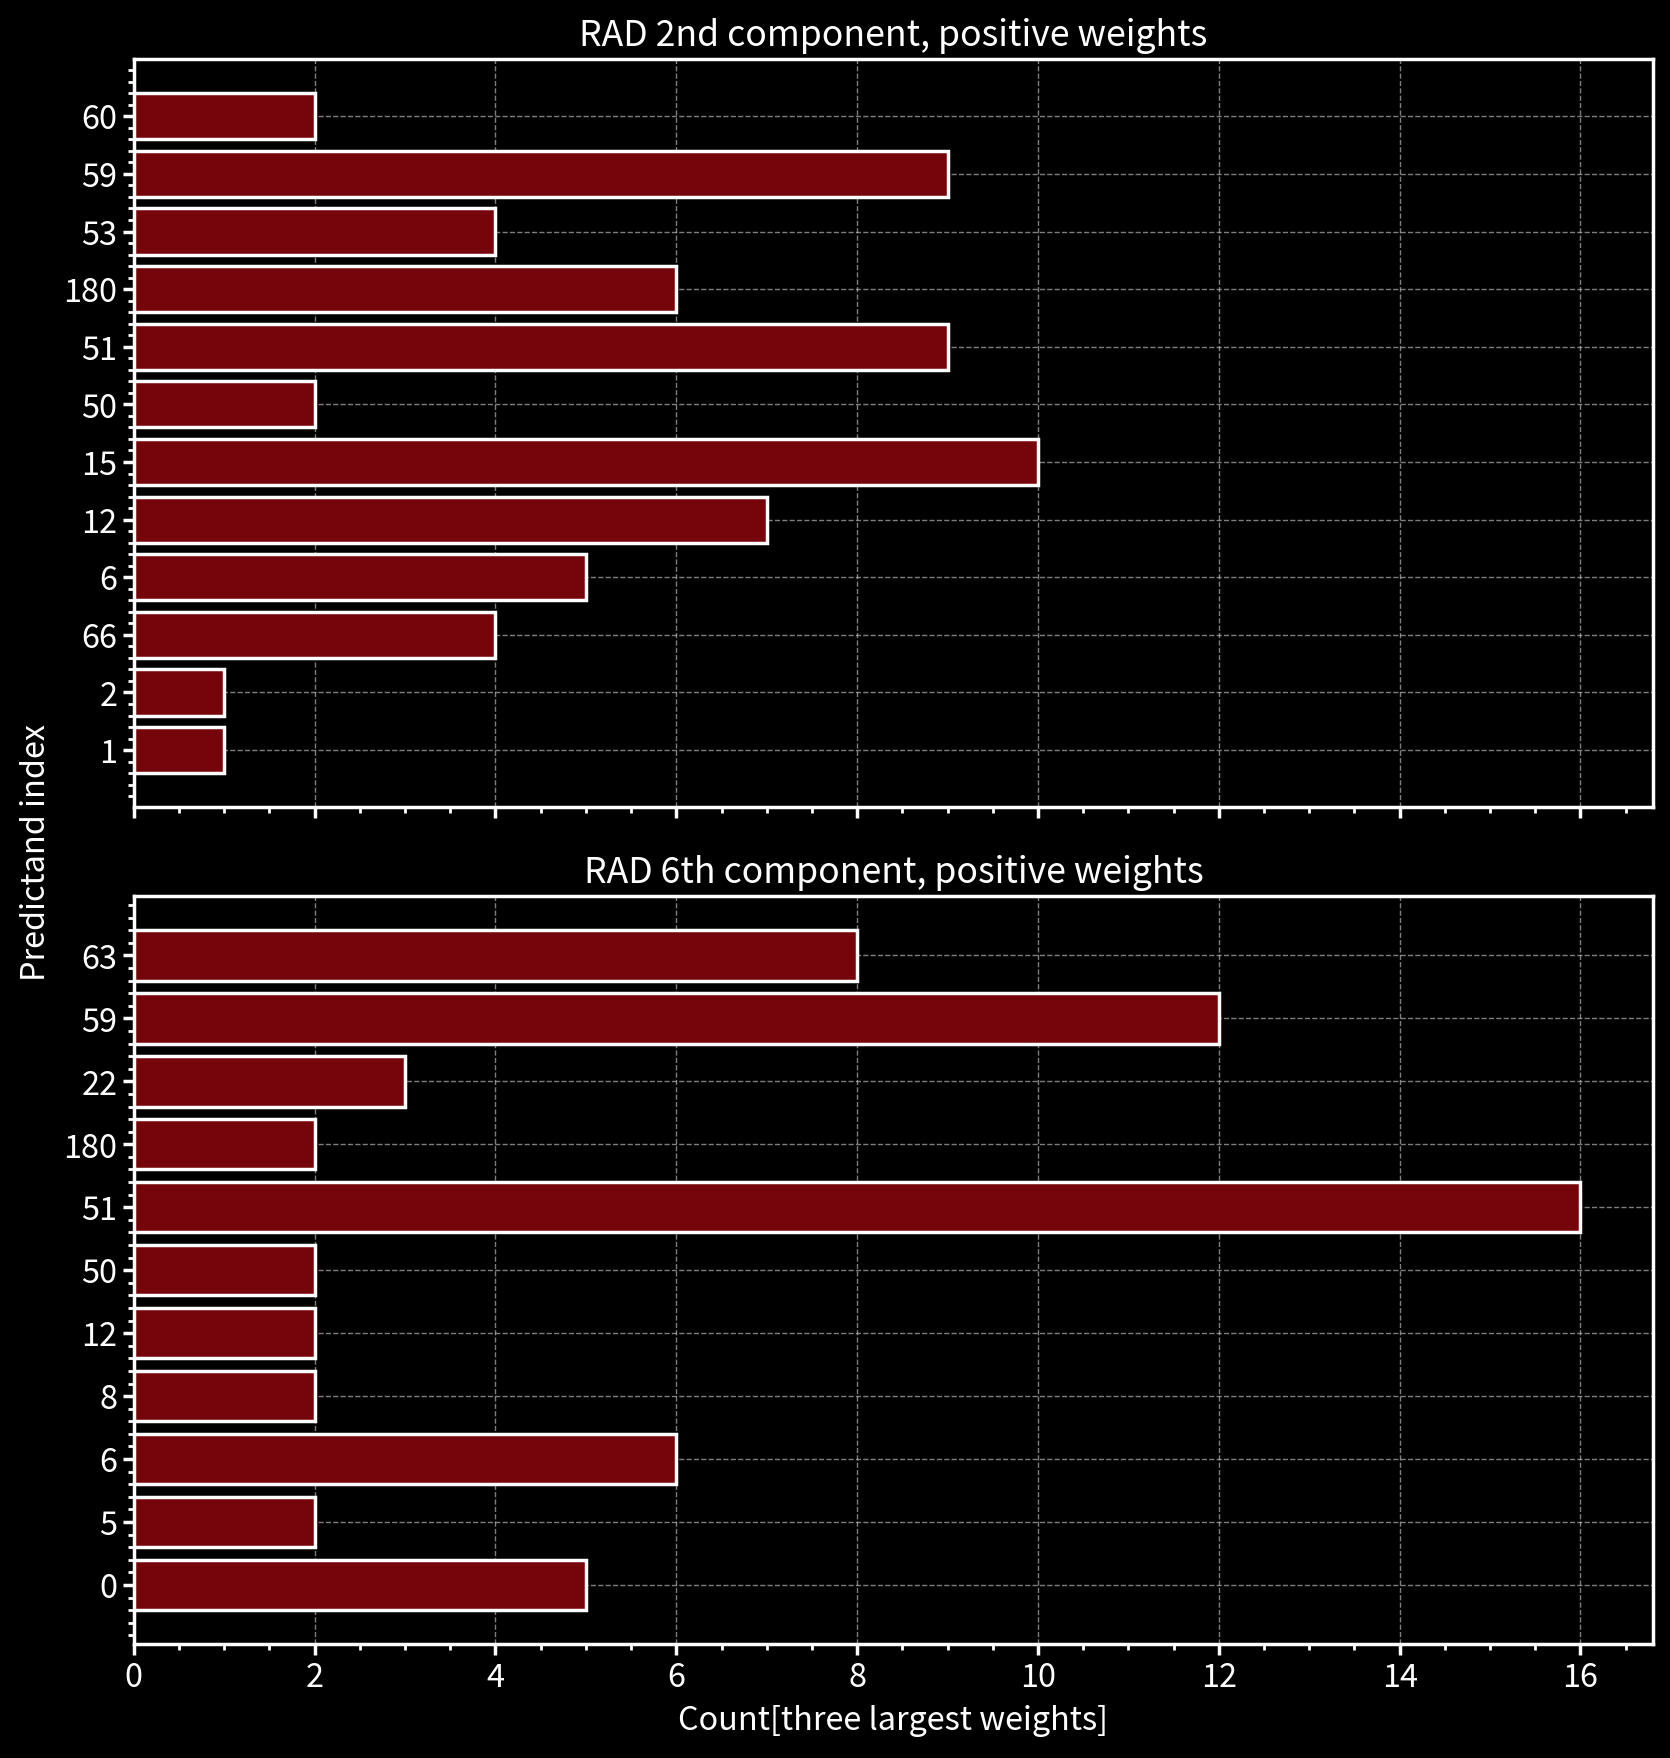

In [47]:
plot.rc.metacolor = 'w'
plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'k','title.color':'w','fontname': 'Source Sans Pro', 'fontsize': 13,'linewidth':1.25})
plot.rc.axesfacecolor = 'k'

#plot.rc.update({'figure.facecolor':'w','axes.labelweight':'ultralight',
#                'tick.labelweight':'ultralight','gridminor.linestyle':'--','title.weight':'normal','linewidth':0.5})

fig,axs = plot.subplots(ncols=1,nrows=2,axwidth=7.595,refaspect=2.031)
kw = dict(color='#75050a', edgecolor='w',edgewidth=1.25)
axs[0].barh(np.arange(0, np.asarray(dict2v).shape[0]),dict2v, **kw,zorder=3)
axs[0].format(ylabel='Predictand index',xlabel='Count[three largest weights]',title='RAD 2nd component, positive weights',yticklabels=dict2k,yticks=np.arange(0, np.asarray(dict2v).shape[0]))
axs[1].barh(np.arange(0, np.asarray(dict6v).shape[0]),dict6v, **kw,zorder=3)
axs[1].format(ylabel='Predictand index',xlabel='Count[three largest weights]',title='RAD 6th component, positive weights',yticklabels=dict6k,yticks=np.arange(0, np.asarray(dict2v).shape[0]))
axs.grid(color='lightgray',lw=0.5,alpha=0.6,ls='--',zorder=0)
#plt.savefig('../figures/0406/RADweights_rank.png',dpi=300,facecolor=fig.get_facecolor())
plt.show()

/tmp/ipykernel_3218691/729790212.py:2: ProplotWarning: rc setting 'linewidth' was renamed to 'meta.width' in version 0.8.
  plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'k','title.color':'w','fontname': 'Source Sans Pro', 'fontsize': 13,'linewidth':1.25})
/tmp/ipykernel_3218691/729790212.py:14: ProplotWarning: Calling arbitrary axes methods from SubplotGrid was deprecated in v0.8 and will be removed in a future release. Please index the grid or loop over the grid instead.
  axs.grid(color='lightgray',lw=0.5,alpha=0.6,ls='--',zorder=0)


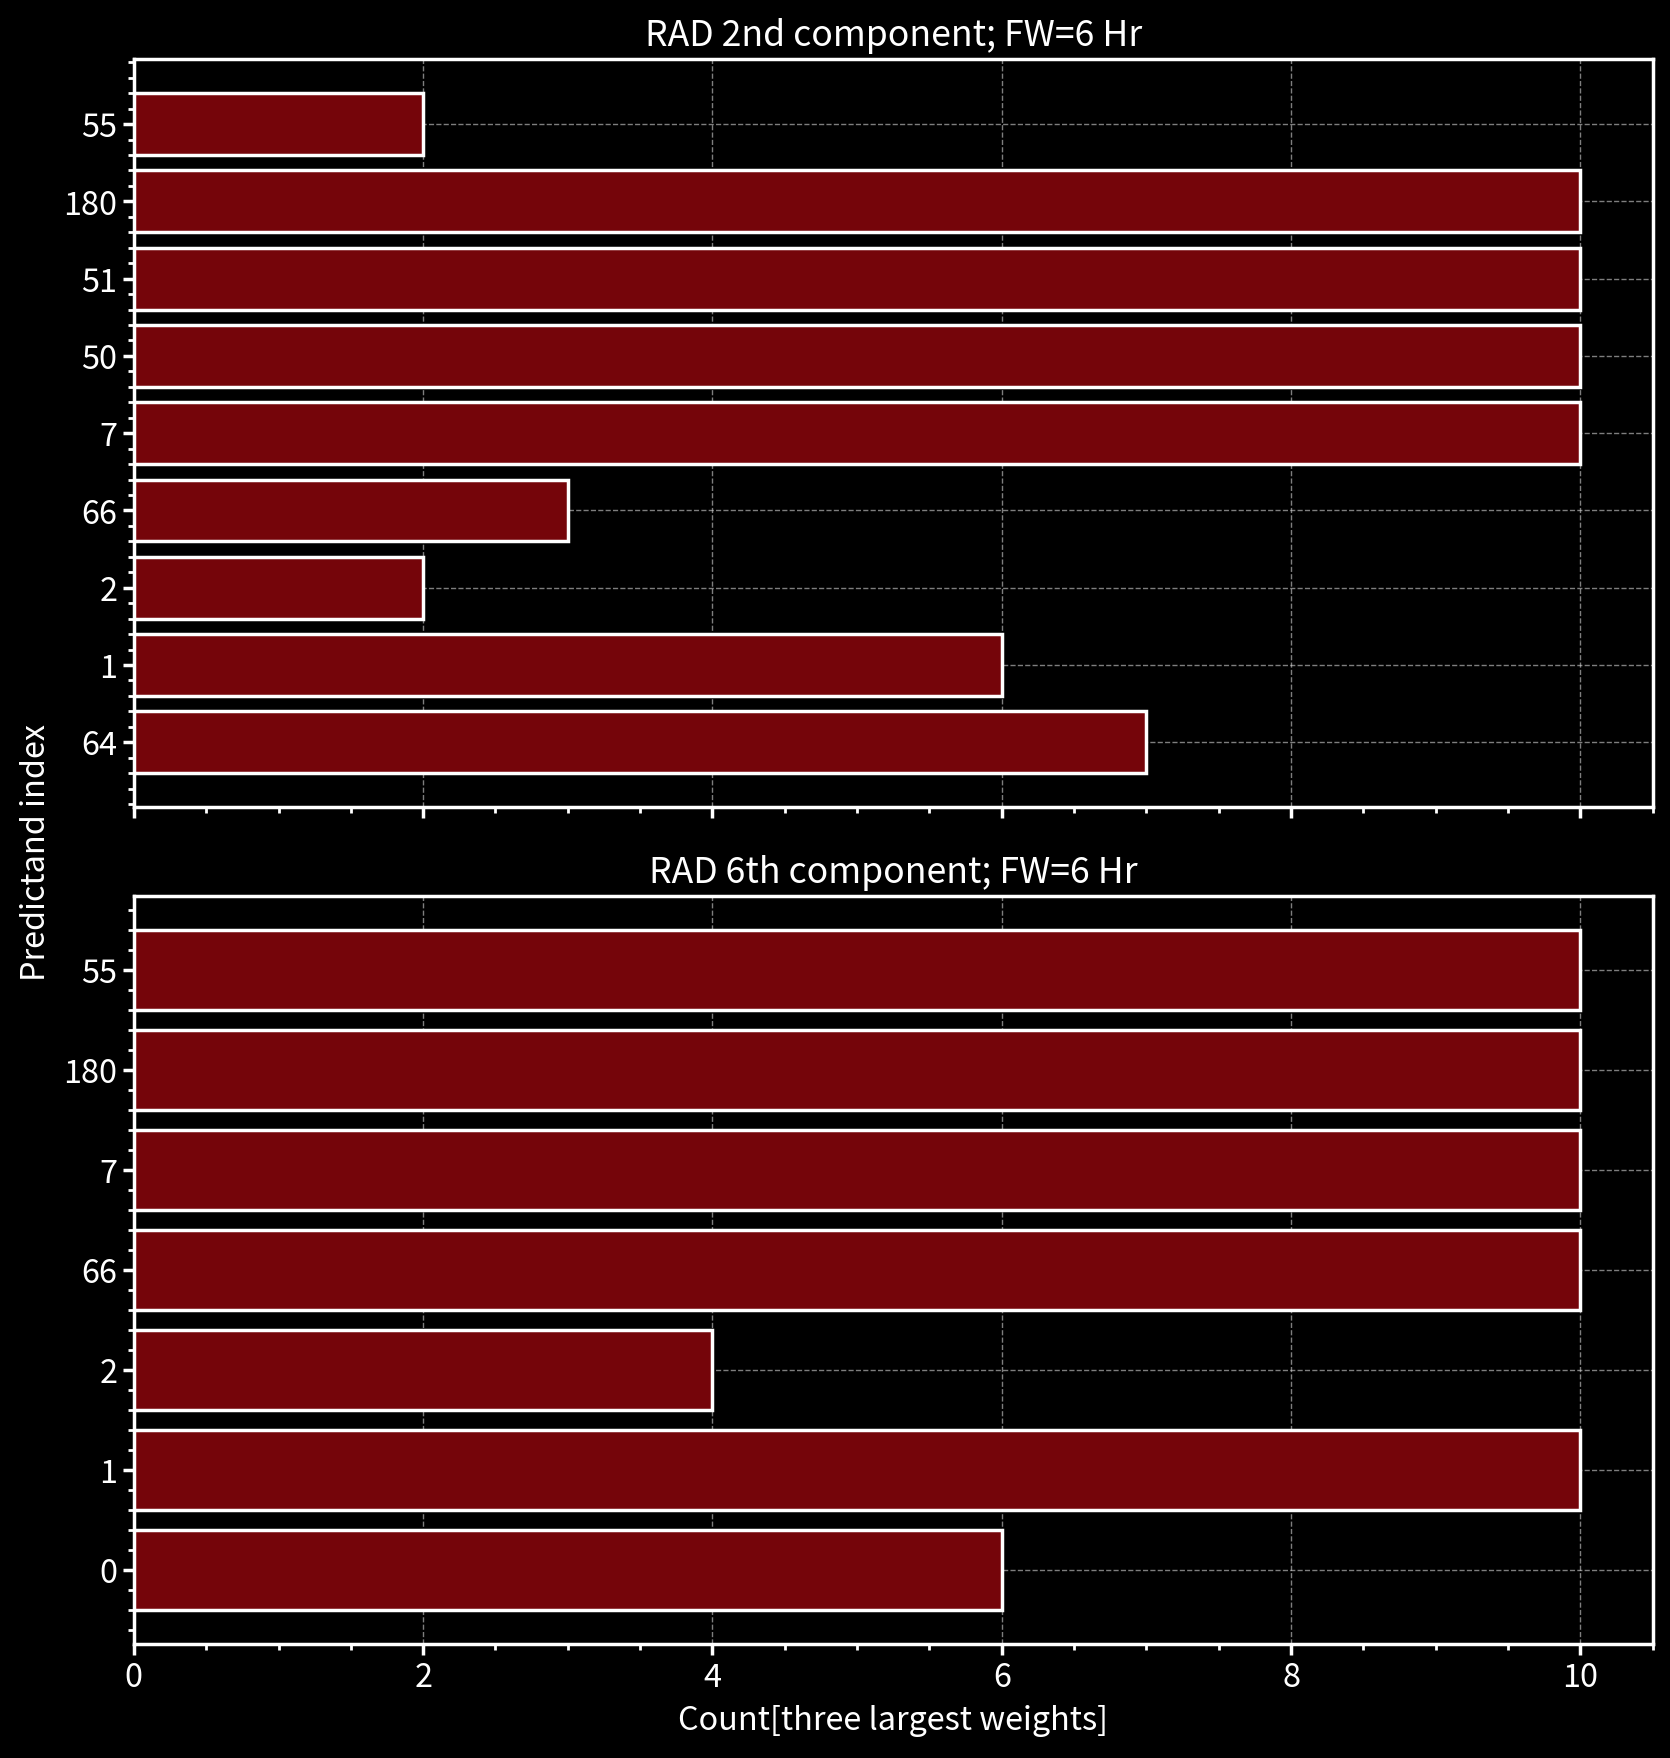

In [67]:
plot.rc.metacolor = 'w'
plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'k','title.color':'w','fontname': 'Source Sans Pro', 'fontsize': 13,'linewidth':1.25})
plot.rc.axesfacecolor = 'k'

#plot.rc.update({'figure.facecolor':'w','axes.labelweight':'ultralight',
#                'tick.labelweight':'ultralight','gridminor.linestyle':'--','title.weight':'normal','linewidth':0.5})

fig,axs = plot.subplots(ncols=1,nrows=2,axwidth=7.595,refaspect=2.031)
kw = dict(color='#75050a', edgecolor='w',edgewidth=1.25)
axs[0].barh(np.arange(0, np.asarray(dict2v).shape[0]),dict2v, **kw,zorder=3)
axs[0].format(ylabel='Predictand index',xlabel='Count[three largest weights]',title='RAD 2nd component; FW=6 Hr',yticklabels=dict2k,yticks=np.arange(0, np.asarray(dict2v).shape[0]))
axs[1].barh(np.arange(0, np.asarray(dict6v).shape[0]),dict6v, **kw,zorder=3)
axs[1].format(ylabel='Predictand index',xlabel='Count[three largest weights]',title='RAD 6th component; FW=6 Hr',yticklabels=dict6k,yticks=np.arange(0, np.asarray(dict2v).shape[0]))
axs.grid(color='lightgray',lw=0.5,alpha=0.6,ls='--',zorder=0)
plt.savefig('../figures/0406/RADweights_rank_FW6_pos.png',dpi=300,facecolor=fig.get_facecolor())
plt.show()

#### Structural Analysis

In [3]:
folderpath='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/testML/output/haiyan/processed/'
PCAdict,dict2 = read_and_proc.depickle(folderpath+'pca/PCA'+'_'+'dict1_g'),read_and_proc.depickle(folderpath+'pca/PCA'+'_'+'dict2_g') #dict1: u,v,w,theta,hdia,rad; dict2:qv,ir
PCAdict['qv'] = (dict2['qv'])
PCAdict['ir'] = (dict2['ir'])

In [4]:
import scipy
def azimuth2angle(azimuth=None):
    """
    https://math.stackexchange.com/questions/926226/conversion-from-azimuth-to-counterclockwise-angle
    """
    angletest = 450-azimuth
    for index,item in enumerate(angletest):
        if item>360:
            angletest[index] = item-360
        else:
            continue
    return angletest

def closest_index(array=None,target=None):
    return np.abs(array-target).argmin()

def polar2cartesian(outcoords, inputshape, origin):
    """Coordinate transform for converting a polar array to Cartesian coordinates. 
    inputshape is a tuple containing the shape of the polar array. origin is a
    tuple containing the x and y indices of where the origin should be in the
    output array."""
    
    xindex, yindex = outcoords
    x0, y0 = origin
    x = xindex - x0
    y = yindex - y0

    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    theta_index = np.round((theta + np.pi) * inputshape[1] / (2 * np.pi))
    return (r,theta_index)

def proc_tocart(polarfield=None,angle=None,twoD=True,standard=False):
    if twoD==True:
        PWnew = [np.asarray(polarfield)[int(np.abs(ANGLE-360).argmin()),:]]
        for i in np.linspace(0,358,359):
            PWnew.append(np.asarray(polarfield)[int(np.abs(ANGLE-i).argmin()),:])
        PWnew = np.swapaxes(np.asarray(PWnew),0,1)
        del i
        
        if standard==True:
            PWnew = (PWnew-np.nanmean(PWnew))/np.nanstd(PWnew)
        else:
            PWnew=PWnew

        test_2cartesian = scipy.ndimage.geometric_transform(PWnew, 
                                                            polar2cartesian,order=0,mode='constant',
                                                            output_shape = \
                                                            (PWnew.shape[0]*2,PWnew.shape[0]*2),
                                                            extra_keywords = \
                                                            {'inputshape':PWnew.shape,
                                                             'origin':(PWnew.shape[0],PWnew.shape[0])})
        #print('Finish processing')
        return ((test_2cartesian))

In [54]:
PCAdict['rad'].explained_variance_ratio_

array([0.38745515, 0.1622033 , 0.03904638, 0.03504233, 0.02323237,
       0.02042159, 0.01924597, 0.01526853, 0.01287619, 0.01257202,
       0.01032773, 0.00952197, 0.00850602, 0.00817417, 0.00747754,
       0.00705791, 0.0064825 , 0.00568575, 0.00540572, 0.0052665 ,
       0.00477224, 0.00457914, 0.004291  , 0.00410552, 0.00406248,
       0.00363116, 0.0034894 , 0.0033856 , 0.00320961, 0.0031102 ,
       0.00303793, 0.00295795, 0.00288647, 0.00276136, 0.00262683,
       0.00255803, 0.00254659, 0.00242623, 0.00241081, 0.00233039,
       0.00226444, 0.00221949, 0.00218831, 0.0020454 , 0.00200552,
       0.00193183, 0.00190442, 0.00185485, 0.00183343, 0.00180987,
       0.0017432 , 0.0017044 , 0.00168323, 0.00167751, 0.00161103,
       0.00160002, 0.00158295, 0.0015175 , 0.00150671, 0.00145549,
       0.00142152, 0.00140292, 0.00138513, 0.00133836, 0.00129349,
       0.00128772, 0.00126618, 0.00124777, 0.00121273, 0.00120998,
       0.00118301, 0.001167  , 0.00114697, 0.0011344 , 0.00110

In [6]:
TEST_rad2 = PCAdict['v'].components_[21,:].reshape(10,360,208) #1
TEST_rad6 = PCAdict['u'].components_[7,:].reshape(10,360,208) #5
TEST_rad7 = PCAdict['u'].components_[26,:].reshape(10,360,208) #5

ANGLE = azimuth2angle(np.linspace(0,359,360))
NEWCART_axis = np.concatenate((np.flipud(-np.linspace(0,207,208)*3),np.linspace(0,207,208)*3))
toplot = [np.fliplr(np.flipud((proc_tocart(TEST_rad2[2,:,:],ANGLE,True,False)))),np.fliplr(np.flipud((proc_tocart(TEST_rad6[2,:,:],ANGLE,True,False)))),np.fliplr(np.flipud((proc_tocart(TEST_rad7[2,:,:],ANGLE,True,False))))]

/tmp/ipykernel_1402975/2377495983.py:2: ProplotWarning: rc setting 'linewidth' was renamed to 'meta.width' in version 0.8.
  plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'k','suptitle.color':'w','title.color':'w','fontname': 'Source Sans Pro', 'fontsize': 13,'linewidth':1.25})


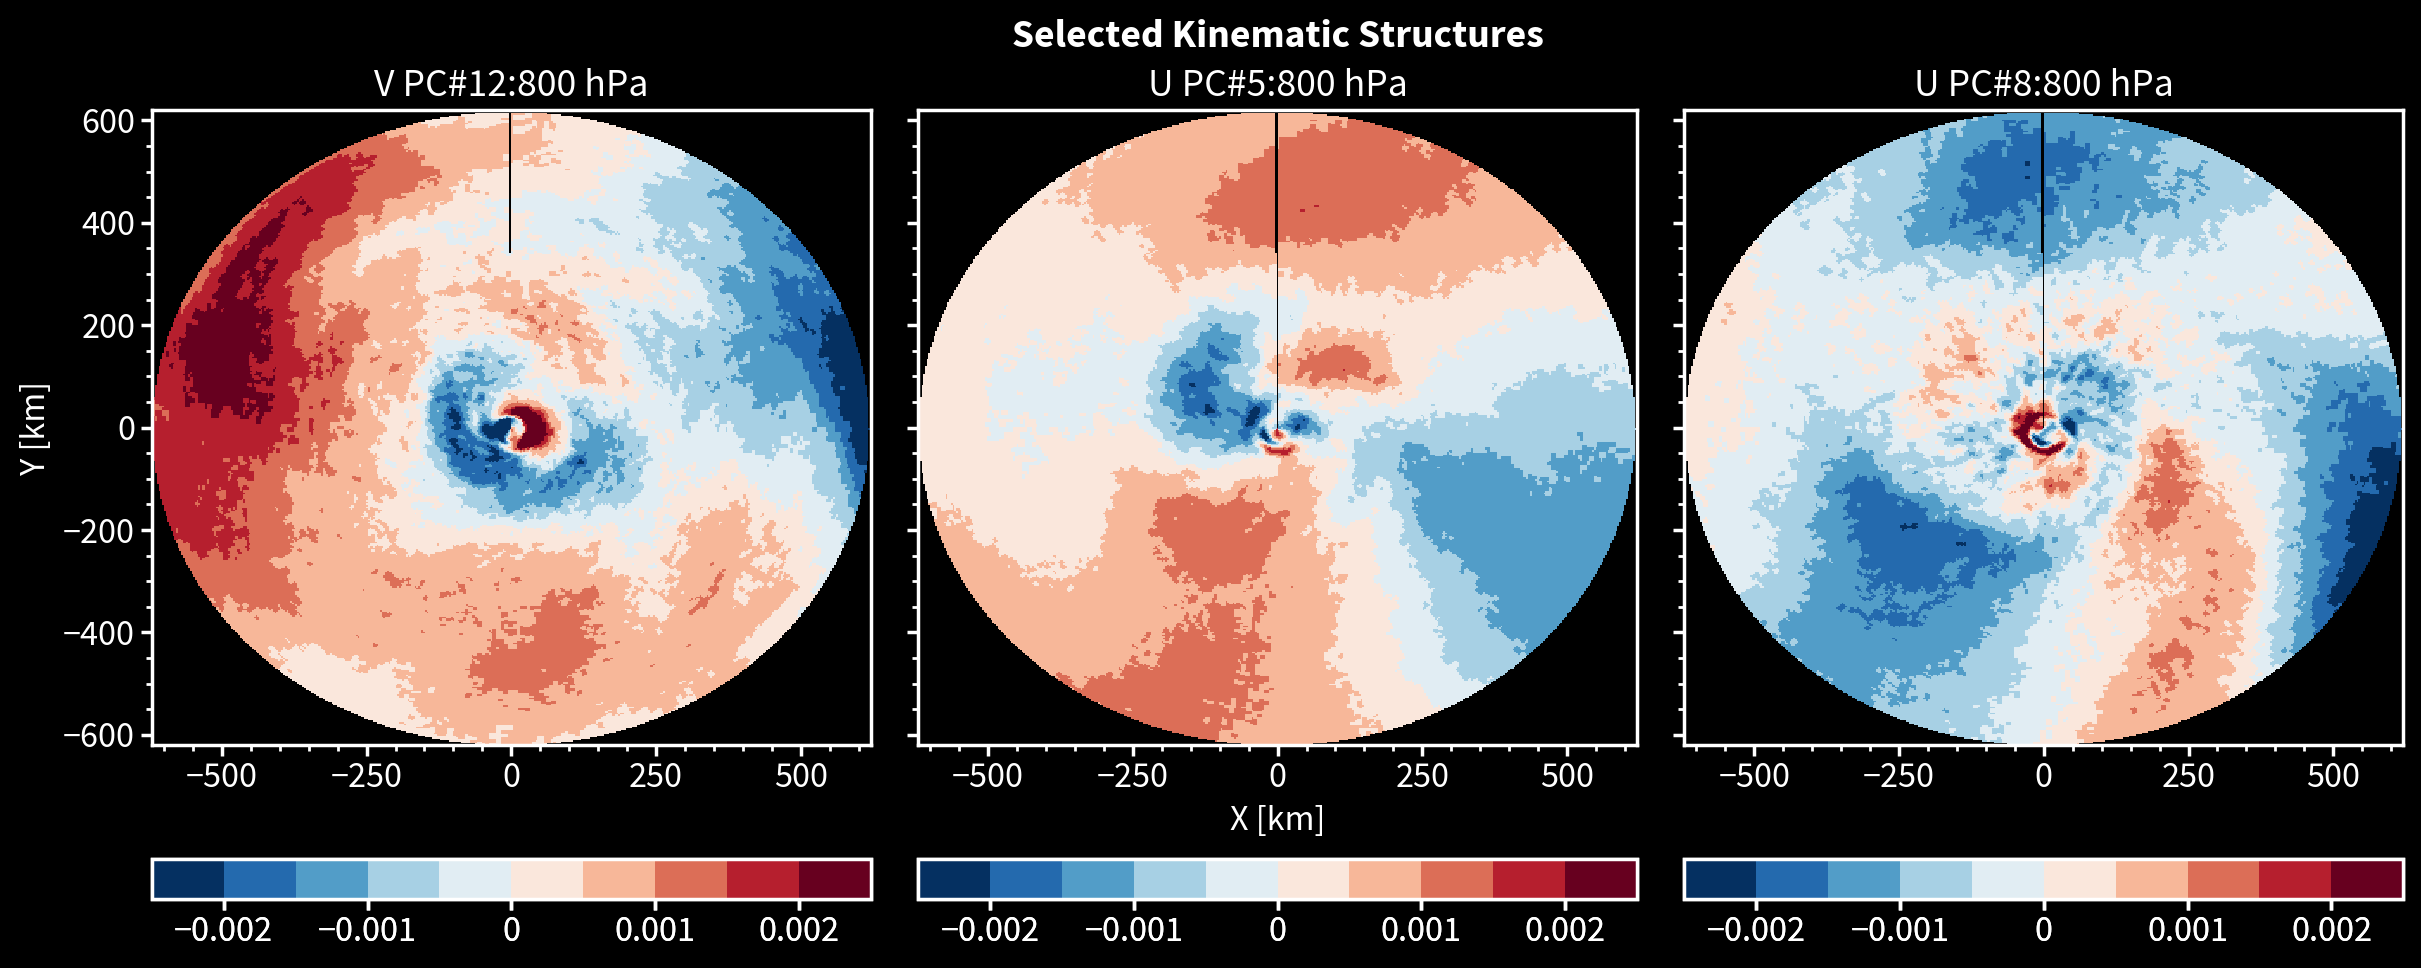

In [32]:
plot.rc.metacolor = 'w'
plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'k','suptitle.color':'w','title.color':'w','fontname': 'Source Sans Pro', 'fontsize': 13,'linewidth':1.25})
plot.rc.axesfacecolor = 'k'

pcex = PCAdict['hdia'].explained_variance_ratio_
index,varN = [12,5,8],['V','U','U']
fig,axs = plot.subplots(ncols=3,nrows=1,axwidth=3.595,refaspect=1.131)
for i in range(3):
    img=axs[i].pcolormesh(np.linspace(-207,207,417)*3,np.linspace(-207,207,417)*3,
                          np.ma.masked_equal(toplot[i],0),cmap='BuRd',vmin=-0.0025,vmax=0.0025) #vmin=-0.0005,vmax=0.0005
    axs[i].colorbar(img,loc='b')
    axs[i].format(ylabel='Y [km]',xlabel='X [km]',title=f'{varN[i]} PC#{index[i]}:{800} hPa',suptitle='Selected Kinematic Structures') #variance:{(pcex[index[i]]*100):.1f}%'
#img=axs[1].pcolormesh(np.linspace(-207,207,417)*3,np.linspace(-207,207,417)*3,np.ma.masked_equal(np.fliplr(np.flipud((proc_tocart(TEST_rad6[2,:,:],ANGLE,True,False)))),0),cmap='BuRd',vmin=-0.0005,vmax=0.0005)
#axs[1].colorbar(img,loc='b')
#axs[1].format(ylabel='Y [km]',xlabel='X [km]',title=f'RAD 6th component:{800} hPa')
plt.savefig('../figures/0430/UVcomp_PCcomp800.png',dpi=300,facecolor=fig.get_facecolor())
plt.show()

/tmp/ipykernel_1531491/872390271.py:2: ProplotWarning: rc setting 'linewidth' was renamed to 'meta.width' in version 0.8.
  plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'k','suptitle.color':'w','title.color':'w','fontname': 'Source Sans Pro', 'fontsize': 13,'linewidth':1.25})


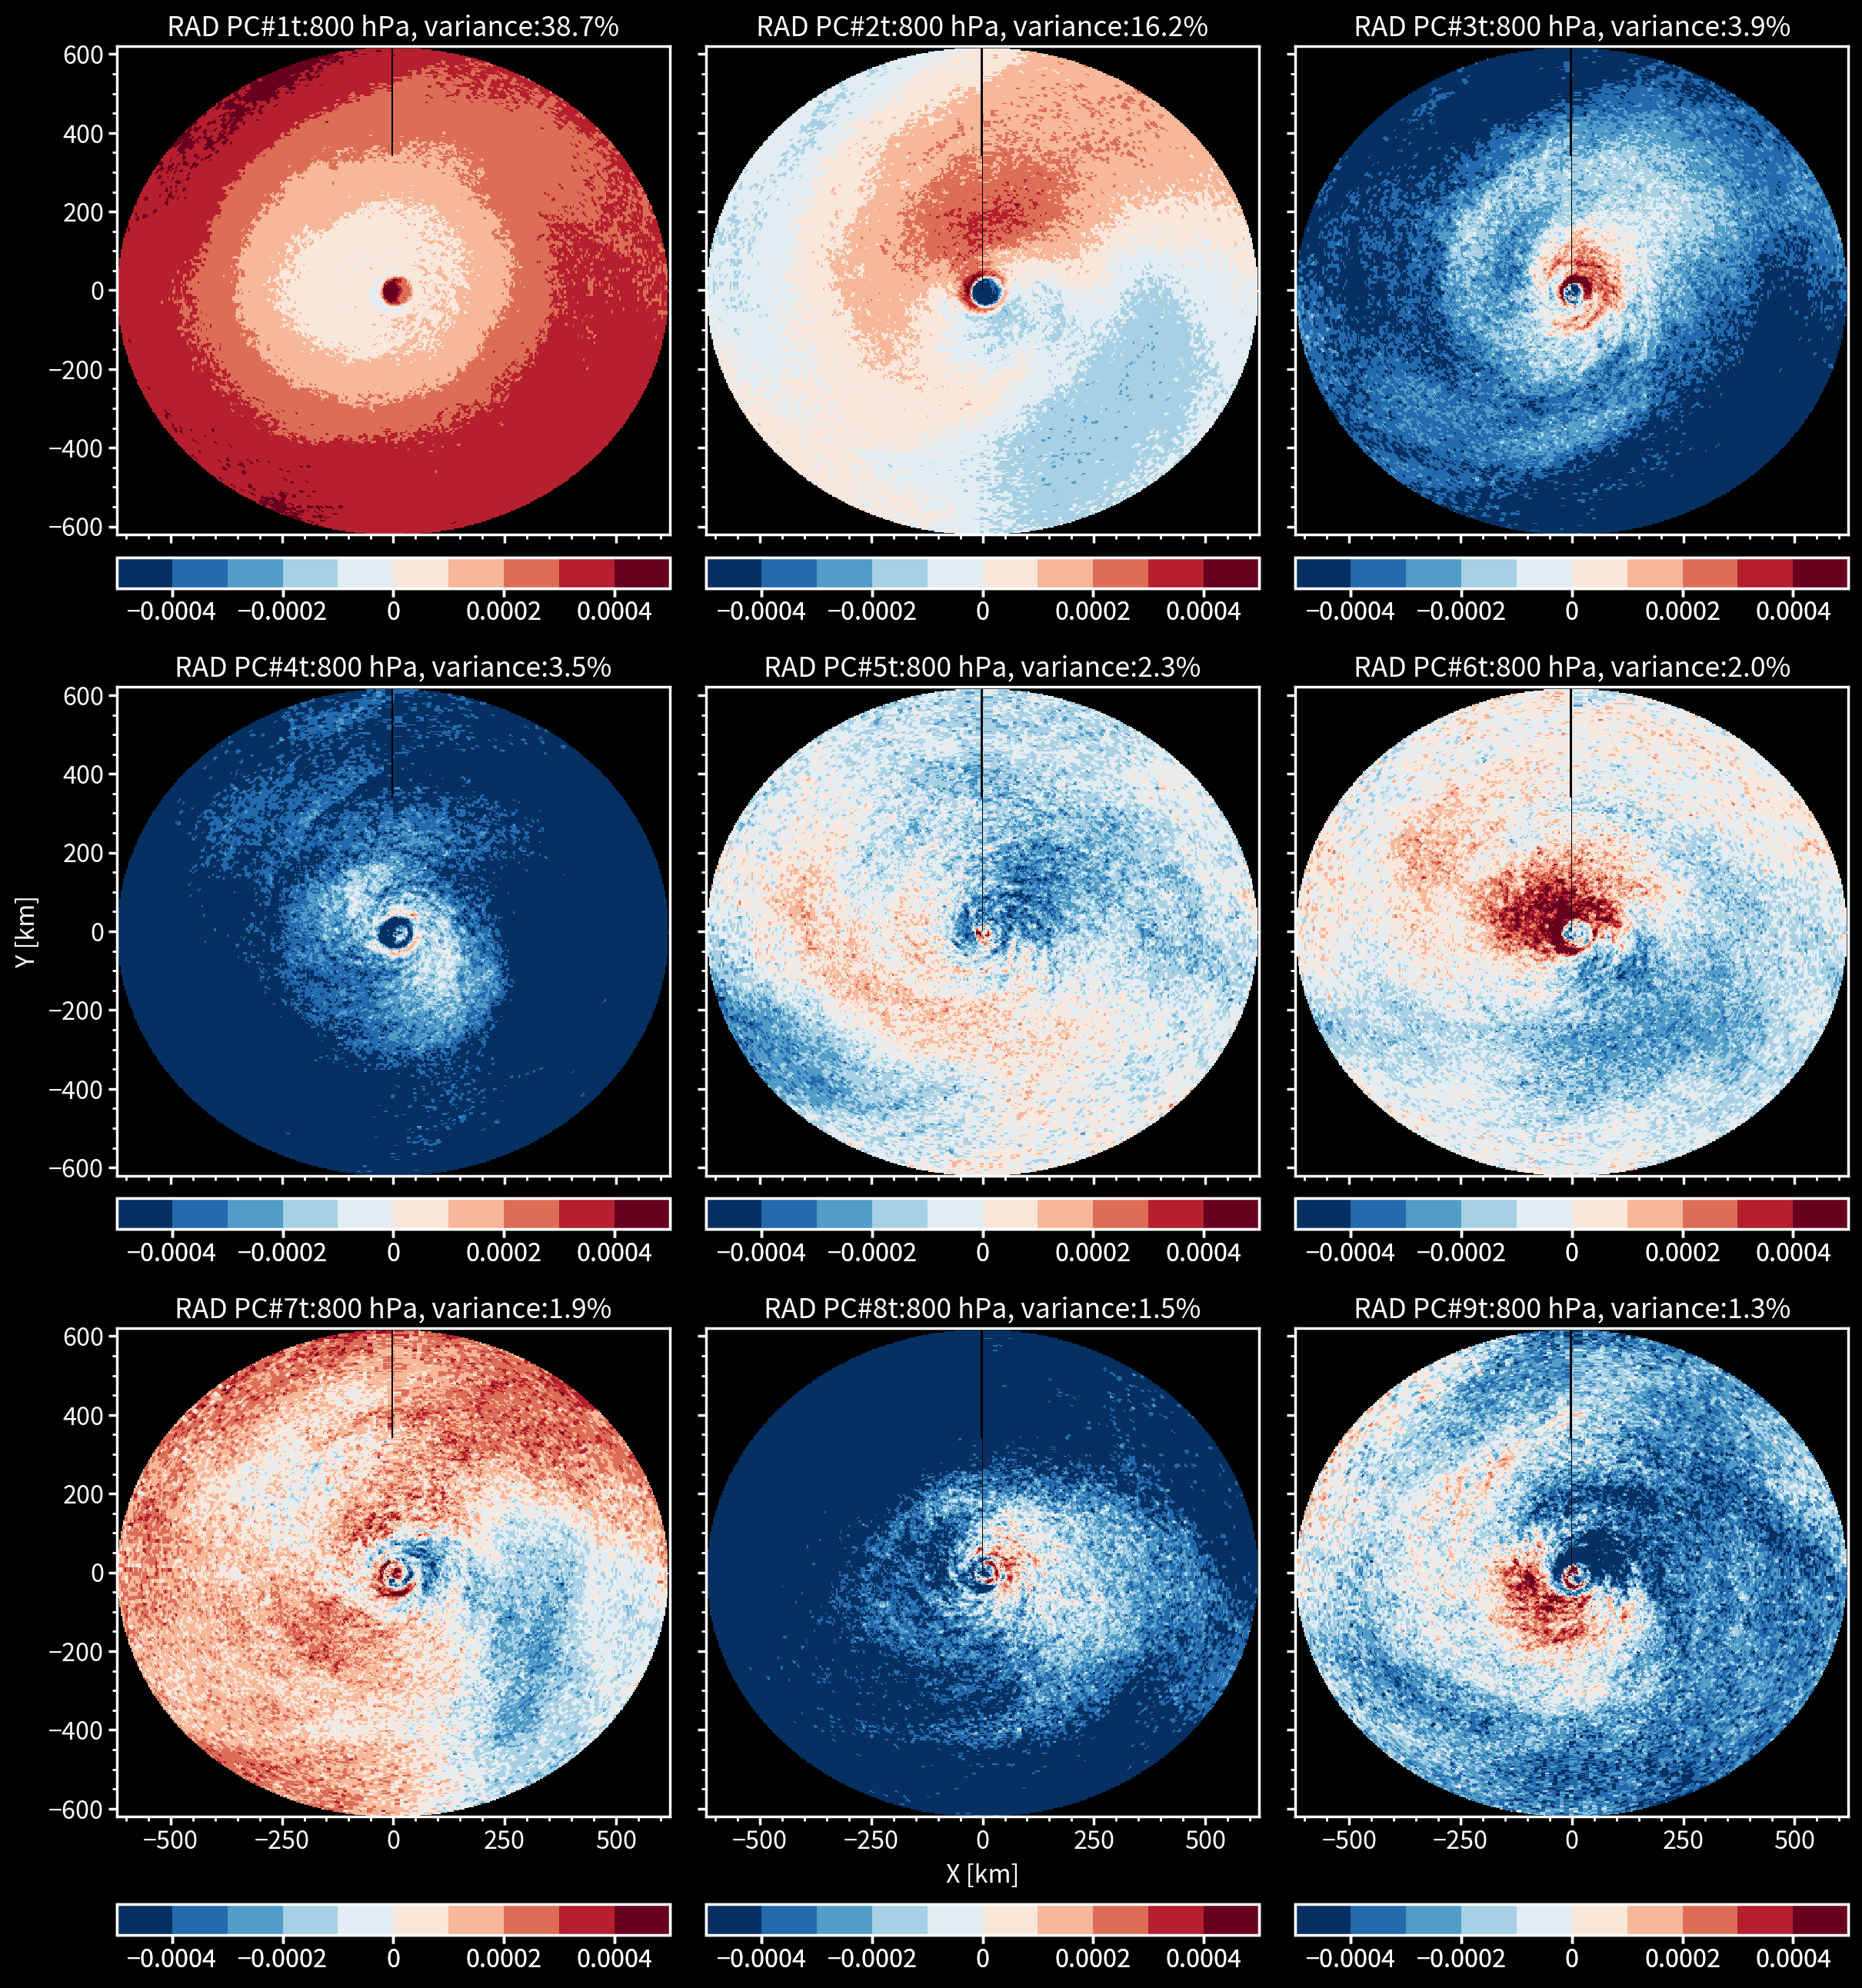

In [9]:
plot.rc.metacolor = 'w'
plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'k','suptitle.color':'w','title.color':'w','fontname': 'Source Sans Pro', 'fontsize': 13,'linewidth':1.25})
plot.rc.axesfacecolor = 'k'

pcex = PCAdict['rad'].explained_variance_ratio_
fig,axs = plot.subplots(ncols=3,nrows=3,axwidth=3.595,refaspect=1.131)
for i in range(9):
    img=axs[i].pcolormesh(np.linspace(-207,207,417)*3,np.linspace(-207,207,417)*3,
                          np.ma.masked_equal(np.fliplr(np.flipud((proc_tocart(PCAdict['rad'].components_[i,:].reshape(10,360,208)[2,:,:],ANGLE,True,False)))),0),cmap='BuRd',vmin=-0.0005,vmax=0.0005) #vmin=-0.0005,vmax=0.0005
    axs[i].colorbar(img,loc='b')
    axs[i].format(ylabel='Y [km]',xlabel='X [km]',title=f'RAD PC#{i+1}t:{800} hPa, variance:{(pcex[i]*100):.1f}%')
#img=axs[1].pcolormesh(np.linspace(-207,207,417)*3,np.linspace(-207,207,417)*3,np.ma.masked_equal(np.fliplr(np.flipud((proc_tocart(TEST_rad6[2,:,:],ANGLE,True,False)))),0),cmap='BuRd',vmin=-0.0005,vmax=0.0005)
#axs[1].colorbar(img,loc='b')
#axs[1].format(ylabel='Y [km]',xlabel='X [km]',title=f'RAD 6th component:{800} hPa')
plt.savefig('../figures/0430/RADcomp_PCcomp800.png',dpi=300,facecolor=fig.get_facecolor())
plt.show()

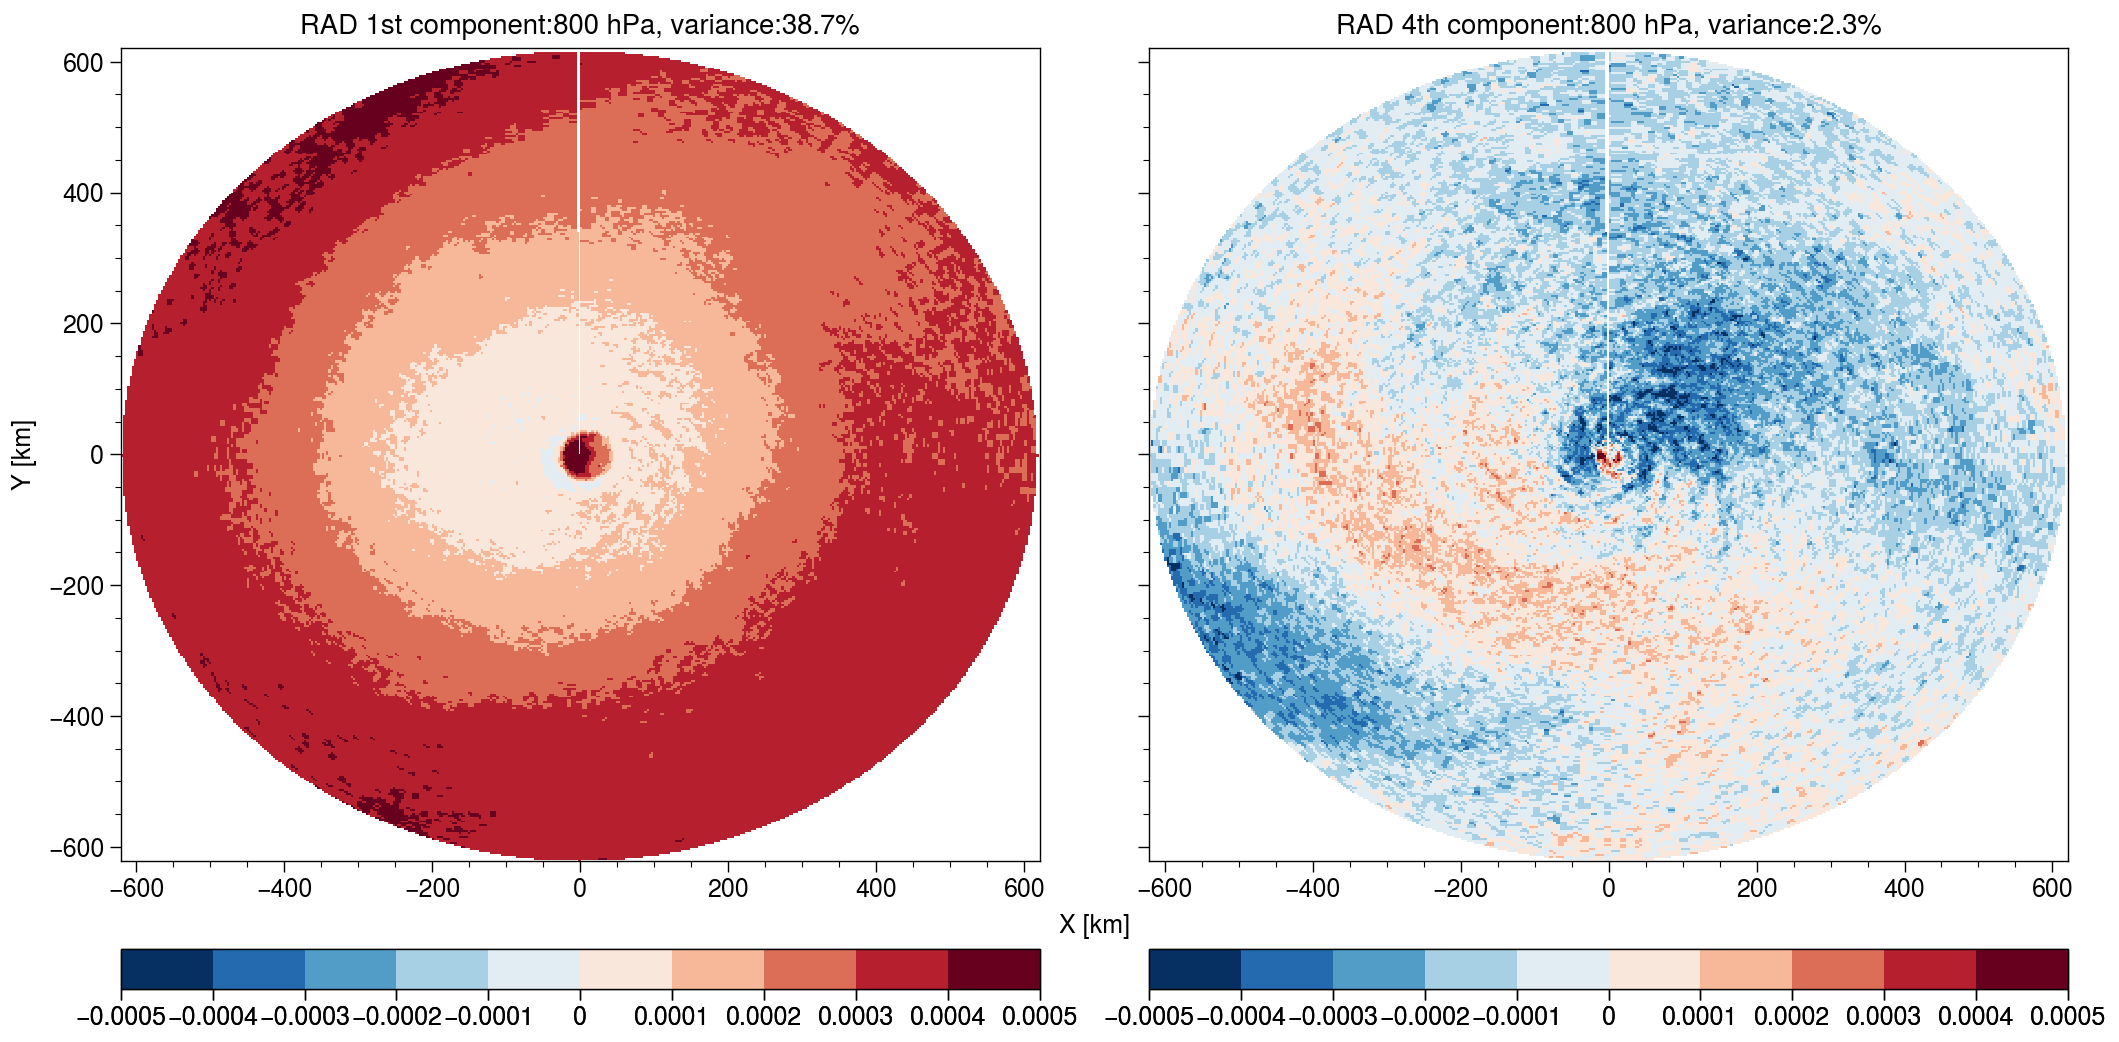

In [22]:
pcex = PCAdict['rad'].explained_variance_ratio_
fig,axs = plot.subplots(ncols=2,nrows=1,axwidth=4.595,refaspect=1.131)
img=axs[0].pcolormesh(np.linspace(-207,207,417)*3,np.linspace(-207,207,417)*3,np.ma.masked_equal(np.fliplr(np.flipud((proc_tocart(TEST_rad2[2,:,:],ANGLE,True,False)))),0),cmap='BuRd',vmin=-0.0005,vmax=0.0005)
axs[0].colorbar(img,loc='b')
axs[0].format(ylabel='Y [km]',xlabel='X [km]',title=f'RAD 1st component:{800} hPa, variance:{(pcex[0]*100):.1f}%')
img=axs[1].pcolormesh(np.linspace(-207,207,417)*3,np.linspace(-207,207,417)*3,np.ma.masked_equal(np.fliplr(np.flipud((proc_tocart(TEST_rad6[2,:,:],ANGLE,True,False)))),0),cmap='BuRd',vmin=-0.0005,vmax=0.0005)
axs[1].colorbar(img,loc='b')
axs[1].format(ylabel='Y [km]',xlabel='X [km]',title=f'RAD 4th component:{800} hPa, variance:{(pcex[4]*100):.1f}%')
#plt.savefig('../figures/0406/RADcomp_rank12.png',dpi=300,facecolor=fig.get_facecolor())
plt.show()

In [80]:
# Important Terms for FW=24Hr
u15,v2,v10 = PCAdict['u'].components_[15,:].reshape(10,360,208),PCAdict['v'].components_[1,:].reshape(10,360,208),PCAdict['v'].components_[9,:].reshape(10,360,208)
# Important Terms for FW=6Hr
#ANGLE = azimuth2angle(np.linspace(0,359,360))
#NEWCART_axis = np.concatenate((np.flipud(-np.linspace(0,207,208)*3),np.linspace(0,207,208)*3))
#u15,v2,v10 = PCAdict['u'].components_[7,:].reshape(10,360,208),PCAdict['v'].components_[0,:].reshape(10,360,208),PCAdict['v'].components_[1,:].reshape(10,360,208)

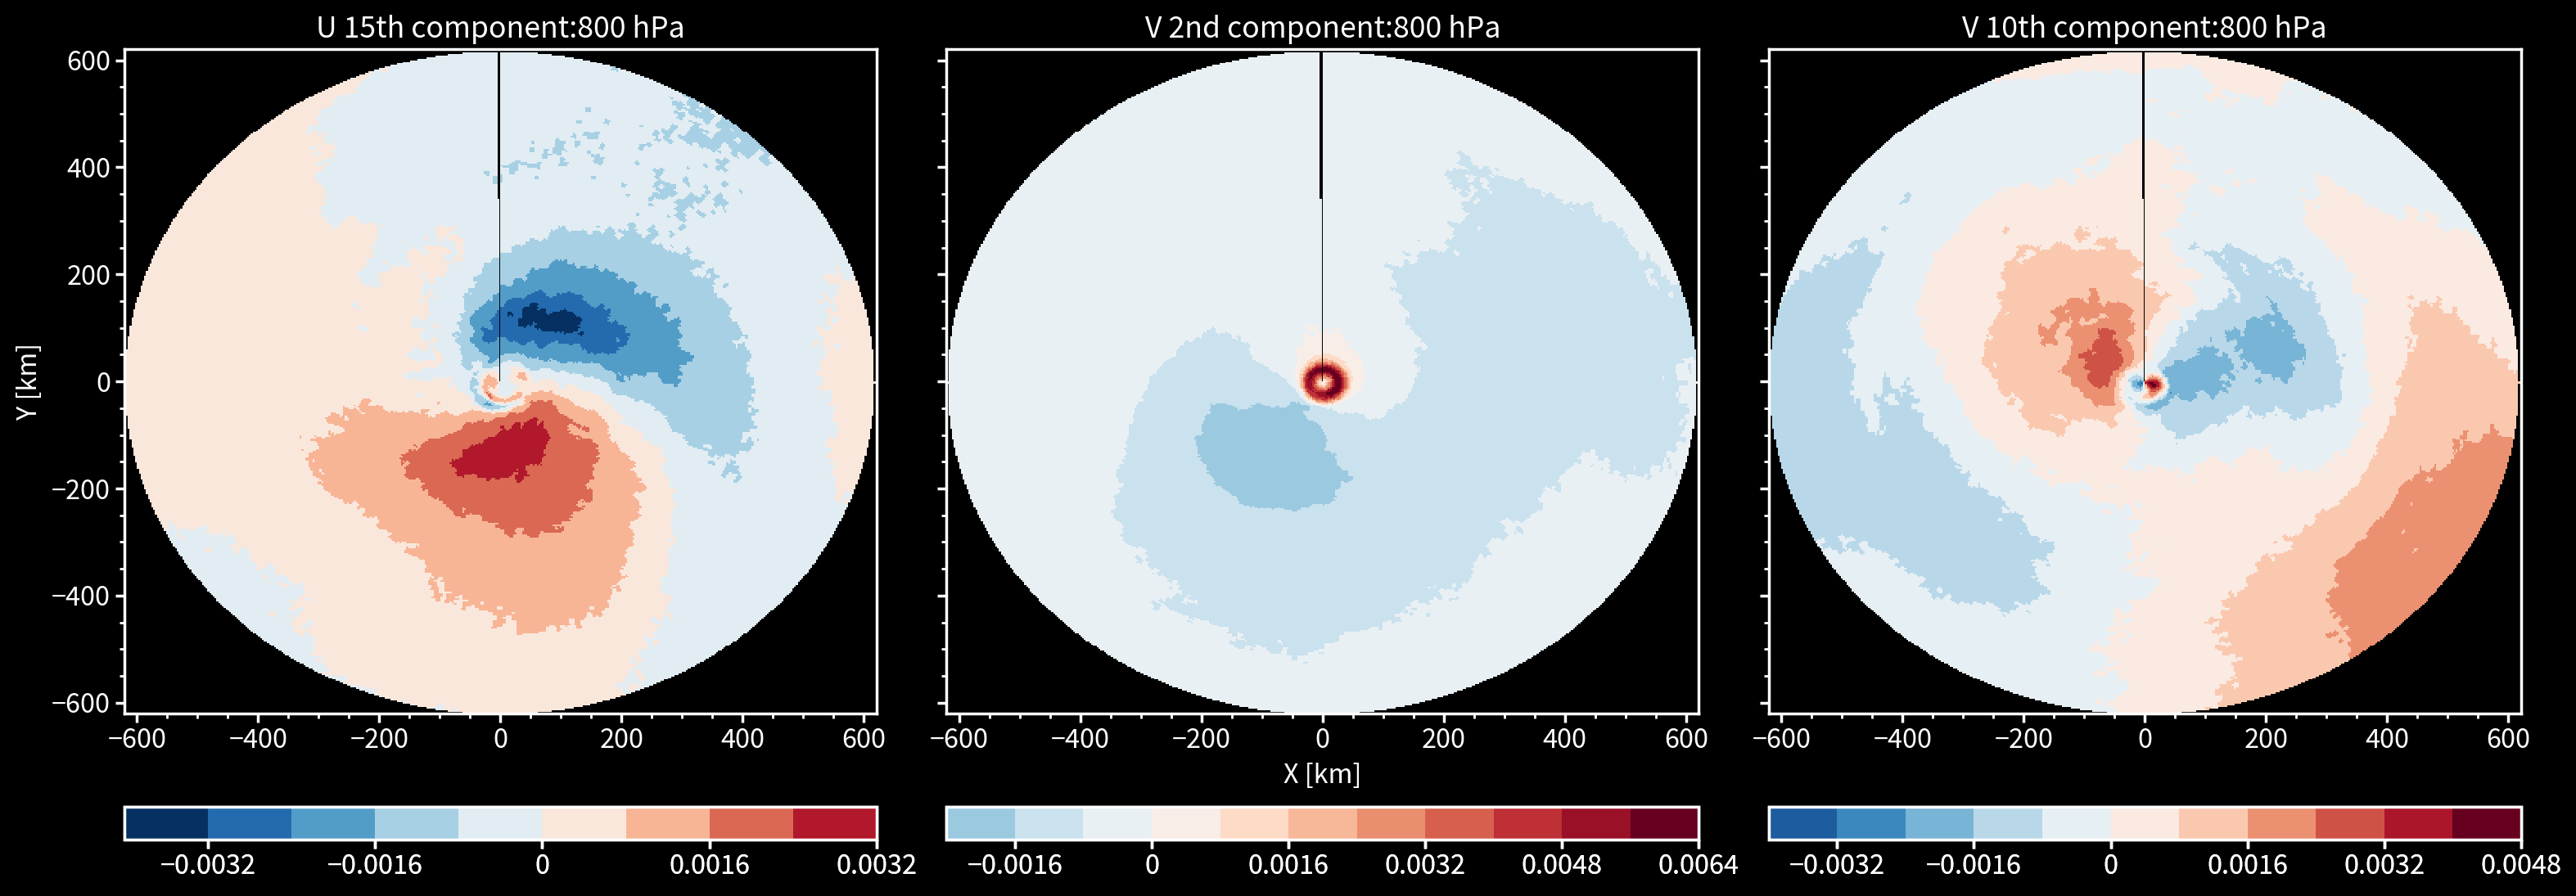

In [73]:
fig,axs = plot.subplots(ncols=3,nrows=1,axwidth=4.595,refaspect=1.131)
img=axs[0].pcolormesh(np.linspace(-207,207,417)*3,np.linspace(-207,207,417)*3,np.ma.masked_equal(np.fliplr(np.flipud((proc_tocart(u15[2,:,:],ANGLE,True,False)))),0),cmap='BuRd')#,vmin=-0.0005,vmax=0.0005)
axs[0].colorbar(img,loc='b')
axs[0].format(ylabel='Y [km]',xlabel='X [km]',title=f'U 15th component:{800} hPa')
img=axs[1].pcolormesh(np.linspace(-207,207,417)*3,np.linspace(-207,207,417)*3,np.ma.masked_equal(np.fliplr(np.flipud((proc_tocart(v2[2,:,:],ANGLE,True,False)))),0),cmap='BuRd')#,vmin=-0.0005,vmax=0.0005)
axs[1].colorbar(img,loc='b')
axs[1].format(ylabel='Y [km]',xlabel='X [km]',title=f'V 2nd component:{800} hPa')
img=axs[2].pcolormesh(np.linspace(-207,207,417)*3,np.linspace(-207,207,417)*3,np.ma.masked_equal(np.fliplr(np.flipud((proc_tocart(v10[2,:,:],ANGLE,True,False)))),0),cmap='BuRd')#,vmin=-0.0005,vmax=0.0005)
axs[2].colorbar(img,loc='b')
axs[2].format(ylabel='Y [km]',xlabel='X [km]',title=f'V 10th component:{800} hPa')
plt.savefig('../figures/0406/UVcomp_rank12.png',dpi=300,facecolor=fig.get_facecolor())
plt.show()

/tmp/ipykernel_3218691/80555970.py:2: ProplotWarning: rc setting 'linewidth' was renamed to 'meta.width' in version 0.8.
  plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'k','title.color':'w','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})


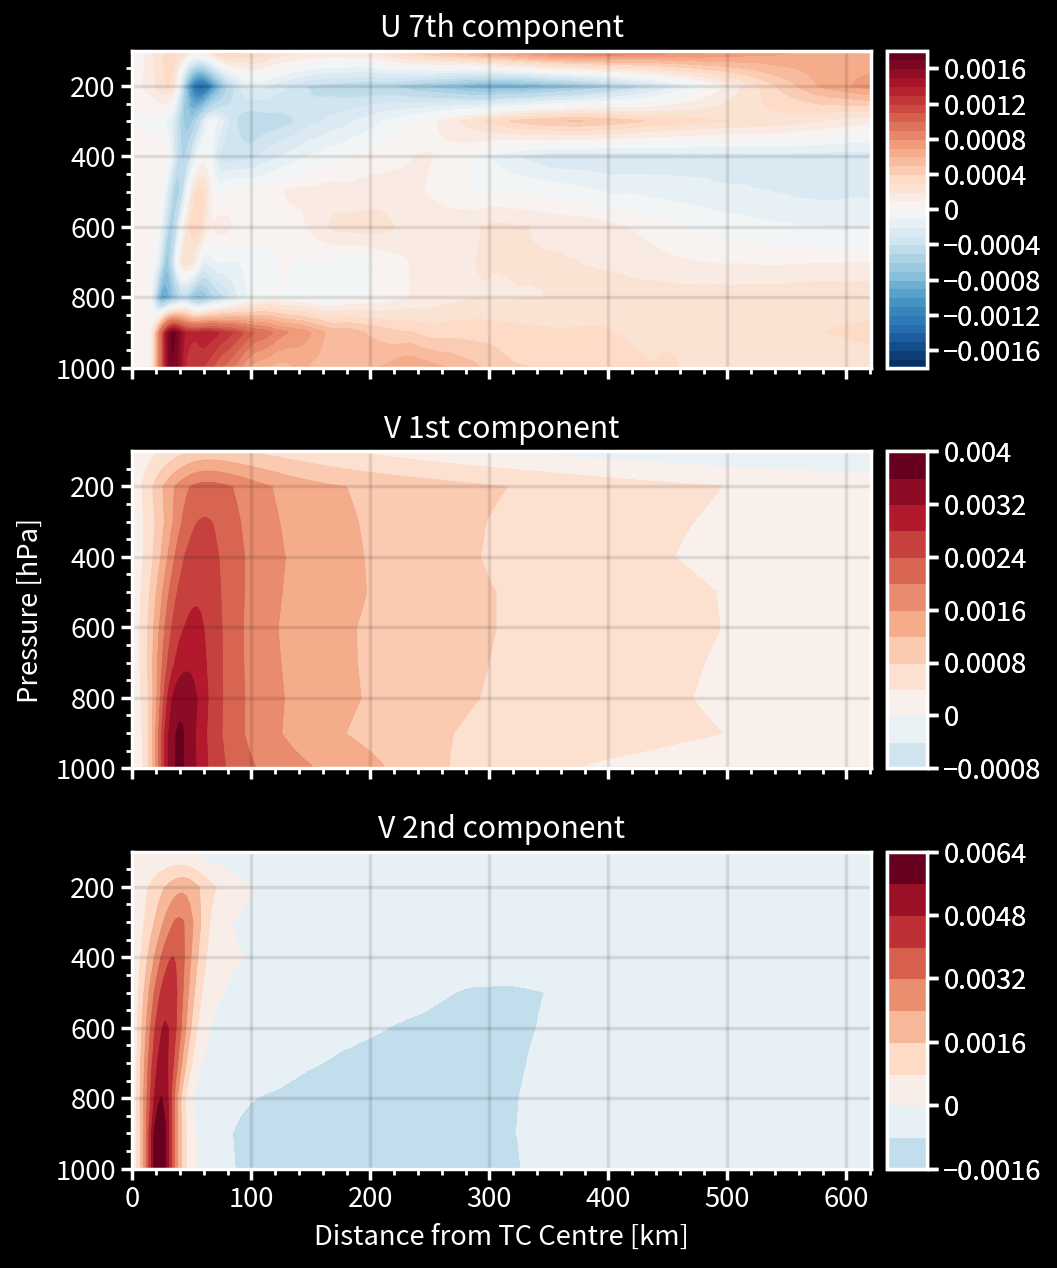

In [76]:
plot.rc.metacolor = 'w'
plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'k','title.color':'w','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})
plot.rc.axesfacecolor = 'k'

fig,axs = plot.subplots(ncols=1,nrows=3,axwidth=3.695,refaspect=2.331)
img=axs[0].contourf(np.linspace(0,207,208)*3,np.linspace(1000,100,10),np.mean(u15,axis=1),cmap='BuRd',levels=np.linspace(-0.0018,0.0018,37))#,vmin=-0.0005,vmax=0.0005)
axs[0].colorbar(img,loc='r')
axs[0].format(ylabel='Pressure [hPa]',xlabel='Distance from TC Centre [km]',ylim=[1000,100],title=f'U 7th component')
img=axs[1].contourf(np.linspace(0,207,208)*3,np.linspace(1000,100,10),np.mean(v2,axis=1),cmap='BuRd')#,vmin=-0.0005,vmax=0.0005)
axs[1].colorbar(img,loc='r')
axs[1].format(ylabel='Pressure [hPa]',xlabel='Distance from TC Centre [km]',ylim=[1000,100],title=f'V 1st component')
img=axs[2].contourf(np.linspace(0,207,208)*3,np.linspace(1000,100,10),np.mean(v10,axis=1),cmap='BuRd')#,vmin=-0.0005,vmax=0.0005)
axs[2].colorbar(img,loc='r')
axs[2].format(ylabel='Pressure [hPa]',xlabel='Distance from TC Centre [km]',ylim=[1000,100],title=f'V 2nd component')
plt.savefig('../figures/0406/UVcomp_rank12_FW6_cross.png',dpi=300,facecolor=fig.get_facecolor())
plt.show()

In [83]:
u15,v2,v10 = PCAdict['u'].components_[6,:].reshape(10,360,208),PCAdict['u'].components_[25,:].reshape(10,360,208),PCAdict['v'].components_[9,:].reshape(10,360,208)